In [125]:
# https://www.kaggle.com/datasets/ahmedshahriarsakib/uber-eats-usa-restaurants-menus?select=restaurant-menus.csv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import Checkbox

from sklearn.impute import SimpleImputer
from ipywidgets import widgets
import os
from IPython.display import clear_output
plt.style.use('Solarize_Light2')


In [92]:
def PrzetworzKategorie(df):
    # nazwy kategorii restauracji zmniejszam do małych liter, oraz rozdzielam do nowych kolumn o nazwach od 0 - 29
    df=df.join(df['category'].str.lower().str.split(',', expand=True))

    df.drop('category', axis=1, inplace=True)

#Tworze kolumny dla każdej osobnej kategorii restauracji
    df_cat_rest=pd.get_dummies(df, drop_first = False, columns= [x for x in range(0,30)], prefix_sep='', prefix='' )


#Sumuje kategorie które dublują się . Nazwy kategorii są w kolumnach o numerach od 8
    df_sum_cat = df_cat_rest.iloc[:,8:].groupby(df_cat_rest.columns[8:], axis=1).sum()
#do tabeli z informacjami o tabeli 
    df_new_rest=df_cat_rest.iloc[:,:8].join(df_sum_cat)
    return df_new_rest

def filter_restaurants(df, prices=[0,1,2,3,4], score_min=0, position_max=1000):
    con1=df['position']<=position_max 
    con2=df['score']>=score_min 
    con3= df['price'].isin(prices)
    return df[con1 & con2 & con3]

def create_cat_table(df_sum_cat):
    df_new_sum =df_sum_cat.sum(axis=0).reset_index()
    df_new_sum.columns=['category', 'sum']
    df_cat=df_new_sum.sort_values('sum', ascending= False).set_index('category')
    df_cat.drop(df_cat[df_cat['sum']<1].index, inplace= True)
    try:
        df_cat.drop('american', axis=0, inplace=True)
    except:
        pass
    df_cat['percent (%)']= df_cat['sum']/ df_cat['sum'].sum()* 100
    return df_cat




In [4]:
df_menu=pd.read_csv('restauracje/restaurant-menus.csv')

df_restaurant=pd.read_csv('restauracje/restaurants.csv')


In [105]:
df_restaurant = df_restaurant.drop(['full_address', 'zip_code'], axis=1)

df_restaurant['price'] = df_restaurant["price_range"].map({None : 0, "$" : 1, "$$" : 2,"$$$" : 3, "$$$$" : 4})
df_restaurant = df_restaurant.drop(['price_range'], axis=1)





KeyError: "['full_address', 'zip_code'] not found in axis"

In [110]:
df_restaurant.isnull().sum()/df_restaurant.count()

id          0.000000
position    0.000000
name        0.000000
score       0.807630
ratings     0.807630
category    0.000572
lat         0.000000
lng         0.000000
price       0.197910
dtype: float64

<bound method NDFrame._add_numeric_operations.<locals>.mean of 0        NaN
1        NaN
2        NaN
3        NaN
4        4.7
        ... 
40222    4.8
40223    4.6
40224    4.7
40225    4.7
40226    4.4
Name: score, Length: 40227, dtype: float64>

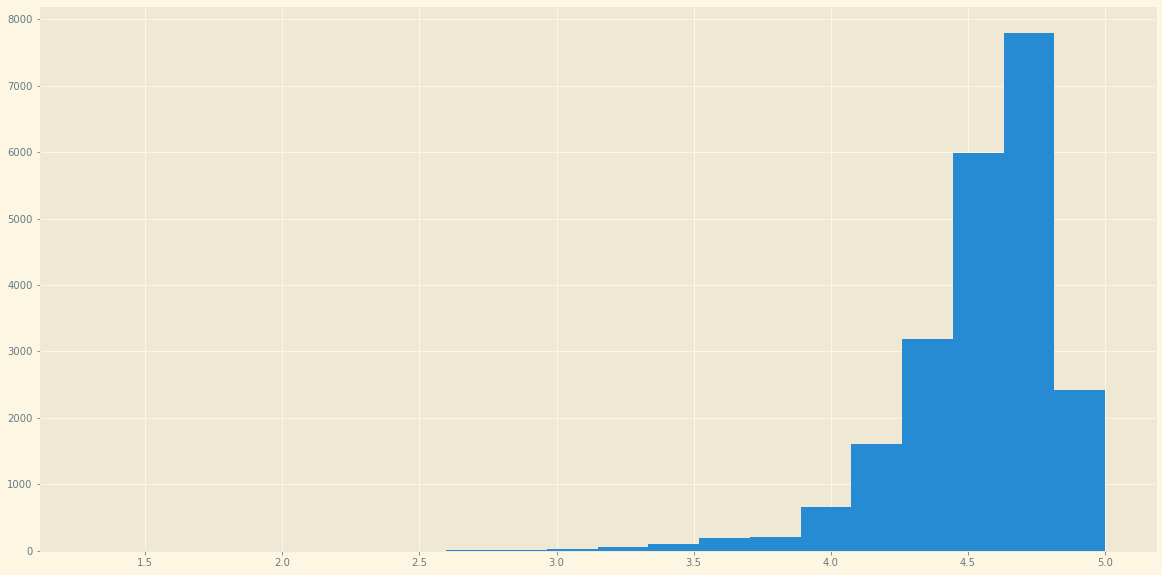

In [113]:
plt.hist(df_restaurant.score, bins=20)


In [117]:
df_restaurant.score.mean()
df_restaurant.score.median()

4.5609957760403095

In [128]:
df_new_rest=PrzetworzKategorie(df_restaurant)

df_new_rest.head()


,id,position,name,score,ratings,lat,lng,price,aapi-owned,adult,...,vegetarian / vegan,vegetarian friendly,vegetarian-friendly,venezuelan,vietnamese,western,western-style japanese food,wine,wings,women-owned
0,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,33.562365,-86.830703,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,9,J' ti`'z Smoothie-N-Coffee Bar,NaN,NaN,33.583640,-86.773330,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,6,Philly Fresh Cheesesteaks (541-B Graymont Ave),NaN,NaN,33.509800,-86.854640,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,17,Papa Murphy's (1580 Montgomery Highway),NaN,NaN,33.404439,-86.806614,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,162,Nelson Brothers Cafe (17th St N),4.7,22.0,33.514730,-86.811700,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:

df_full_rest = df_new_rest.copy()
mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')
df_full_rest['price'] = median_imputer.fit_transform(df_full_rest['price'].values.reshape(-1,1))
df_full_rest['score'] = mean_imputer.fit_transform(df_full_rest['score'].values.reshape(-1,1))

df_full_rest.head()

df_new_rest=df_full_rest.copy()

In [88]:
boxP0 = Checkbox(False, description='Price 0')
boxP1= Checkbox(False, description='Price 1')
boxP2 = Checkbox(False, description='Price 2')
boxP3 = Checkbox(False, description='Price 3')
boxP4 = Checkbox(False, description='Price 4')

###RangeSlider
min_score = widgets.FloatSlider(
    value=2.0,
    min=1.0,
    max=5.0,
    step=0.1,
    description='Minimalna ocena:',
    continuous_update=False
)
max_pos = widgets.IntSlider(
    value=3,
    min=1.0,
    max=100,
    step=1.0,
    description='Maksymalna pozycja w wyszukiwarce:',
    continuous_update=False
)


container = widgets.HBox(children=[boxP0, boxP1, boxP2, boxP3,boxP4 ])
container2 = widgets.HBox(children=[min_score, max_pos ])
display(container, alignment=False)
display(container2, alignment=False)
def changed(b):
    clear_output()
    display(container, alignment=False)
    display(container2, alignment=False)
    df_filtered= filter_restaurants(df_new_rest, position_max=max_pos.value, prices =[ i for i, value in enumerate([boxP0.value, boxP1.value, boxP2.value, boxP3.value, boxP4.value]) if value == True], score_min=min_score.value)

#Wypisuje najlepsze restauracje ( 10 najlepszych) sortując po position malejąco, score rosnąco, ratings rosnąco
    a=df_filtered.sort_values(['position', 'score', 'ratings'], ascending= [True, False, False]).head(10)
    display(a)

boxP0.observe(changed,names="value")
boxP1.observe(changed,names="value")
boxP2.observe(changed,names="value")
boxP3.observe(changed,names="value")
boxP4.observe(changed,names="value")
max_pos.observe(changed,names="value")
min_score.observe(changed,names="value")



,id,position,name,score,ratings,lat,lng,price,aapi-owned,adult,...,vegetarian / vegan,vegetarian friendly,vegetarian-friendly,venezuelan,vietnamese,western,western-style japanese food,wine,wings,women-owned


 Ilosc restauracji: 550


,sum,percent (%)
category,,
american,10008,7.191102
fast food,4608,3.311011
burgers,4235,3.042997
sandwiches,4208,3.023597
sandwich,4123,2.962521
family meals,4066,2.921565
healthy,3782,2.717501
comfort food,3565,2.561578
asian,3141,2.256919


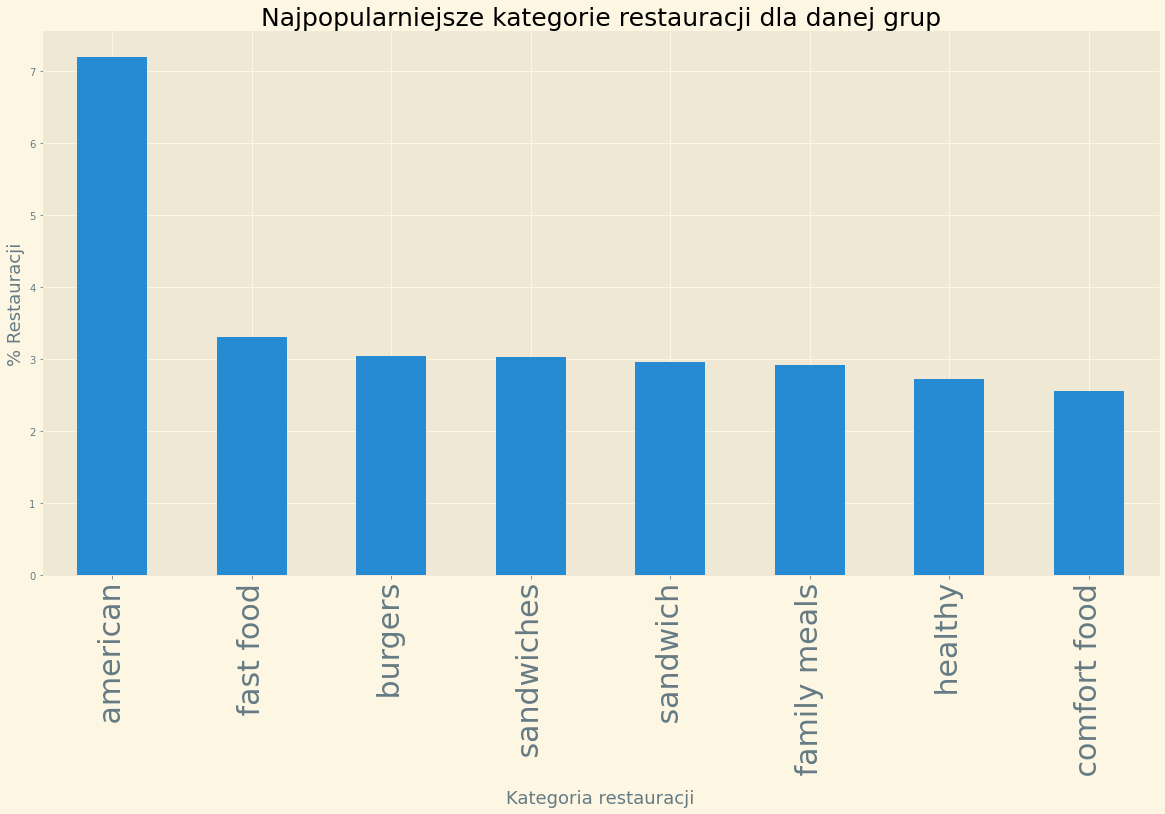

In [136]:
boxP0 = Checkbox(False, description='Price 0')
boxP1= Checkbox(False, description='Price 1')
boxP2 = Checkbox(False, description='Price 2')
boxP3 = Checkbox(False, description='Price 3')
boxP4 = Checkbox(False, description='Price 4')

###RangeSlider
min_score = widgets.FloatSlider(
    value=2.0,
    min=1.0,
    max=5.0,
    step=0.1,
    description='Minimalna ocena:',
    continuous_update=False
)
max_pos = widgets.IntSlider(
    value=3,
    min=1.0,
    max=300,
    step=1.0,
    description='Maksymalna pozycja w wyszukiwarce:',
    continuous_update=False
)


container = widgets.HBox(children=[boxP0, boxP1, boxP2, boxP3,boxP4 ])
container2 = widgets.HBox(children=[min_score, max_pos ])
display(container, alignment=False)
display(container2, alignment=False)
def changed(b):
    clear_output()
    display(container, alignment=False)
    display(container2, alignment=False)
    df_filtered= filter_restaurants(df_new_rest, position_max=max_pos.value, prices =[ i for i, value in enumerate([boxP0.value, boxP1.value, boxP2.value, boxP3.value, boxP4.value]) if value == True], score_min=min_score.value)
    cat_table =create_cat_table(df_filtered.iloc[:,8:])
    print(f" Ilosc restauracji: {cat_table['sum'].count()}")
    display(cat_table.head(10))

    

    plt.rcParams["figure.figsize"] = (20,10)
    data_chart = cat_table.iloc[:8, -1].plot.bar()


    data_chart.set_xlabel('Kategoria restauracji', fontsize=18)
    data_chart.set_ylabel('% Restauracji', fontsize=18)
    data_chart.set_title('Najpopularniejsze kategorie restauracji dla danej grup', fontsize=25)
    plt.xticks(fontsize=30)
    plt.show()

    #plt.bar(cat_table.iloc[:10,:].index,cat_table.iloc[:10,0])


boxP0.observe(changed,names="value")
boxP1.observe(changed,names="value")
boxP2.observe(changed,names="value")
boxP3.observe(changed,names="value")
boxP4.observe(changed,names="value")
max_pos.observe(changed,names="value")
min_score.observe(changed,names="value")



In [399]:
# Badanie popularności kategorii dań w restauracjach

df_menu.groupby('category').count().sort_values(['restaurant_id'], ascending=False).head(5)
#df_pop_menu

,restaurant_id,name,description,price
category,,,,
Picked for you,145401,145401,119673,145401
Beverages,103391,103391,47436,103391
Sandwiches,102730,102730,98714,102730
Sides,93354,93354,46435,93354
Drinks,85904,85904,41634,85904


In [401]:
# Łączenie tabelii restauracji z tabelą menu
min_price=1
max_price=4

df_rest_pric=df_restaurant[(df_restaurant['price']>=min_price) & (df_restaurant['price']<=max_price)]
df_rest_merge = pd.merge(df_rest_pric, df_menu, left_on='id', right_on='restaurant_id', how='left')


In [404]:
df_rest_merge

,id,position,name_x,score,ratings,category_x,lat,lng,price_x,restaurant_id,category_y,name_y,description,price_y
0,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",33.562365,-86.830703,1.0,1.0,Extra Large Pizza,Extra Large Meat Lovers,Whole pie.,15.99 USD
1,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",33.562365,-86.830703,1.0,1.0,Extra Large Pizza,Extra Large Supreme,Whole pie.,15.99 USD
2,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",33.562365,-86.830703,1.0,1.0,Extra Large Pizza,Extra Large Pepperoni,Whole pie.,14.99 USD
3,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",33.562365,-86.830703,1.0,1.0,Extra Large Pizza,Extra Large BBQ Chicken &amp; Bacon,Whole Pie,15.99 USD
4,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",33.562365,-86.830703,1.0,1.0,Extra Large Pizza,Extra Large 5 Cheese,Whole pie.,14.99 USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988227,40227,50,Beijing Wok,4.4,254.0,"Chinese, Asian, Asian Fusion, Family Friendly,...",30.202210,-97.838689,1.0,40227.0,Kid’s Mains,Lion Plate,BBQ skewer two pices and fantail shrimp two pi...,8.55 USD
2988228,40227,50,Beijing Wok,4.4,254.0,"Chinese, Asian, Asian Fusion, Family Friendly,...",30.202210,-97.838689,1.0,40227.0,Beverages,Soft Drinks,NaN,1.95 USD
2988229,40227,50,Beijing Wok,4.4,254.0,"Chinese, Asian, Asian Fusion, Family Friendly,...",30.202210,-97.838689,1.0,40227.0,Beverages,Iced Tea,NaN,1.95 USD
2988230,40227,50,Beijing Wok,4.4,254.0,"Chinese, Asian, Asian Fusion, Family Friendly,...",30.202210,-97.838689,1.0,40227.0,Desserts,Sesame Balls (4 pcs),NaN,3.95 USD


In [405]:
# Średnia ilość oraz średnia cena dla kategorii cenowych
tdf=df_rest_merge.groupby('price_x').mean()
tdf['count']=df_rest_merge.groupby('price_x')[['id']].count()
tdf.head()

,id,position,score,ratings,lat,lng,restaurant_id,count
price_x,,,,,,,,
1.0,19858.055020,56.737690,4.577270,80.999936,40.199554,-95.806945,19858.011518,2377072
2.0,19410.385341,69.459569,4.541964,92.630883,39.699136,-94.993482,19410.338148,601154
3.0,18847.982920,112.693774,4.621466,84.195394,40.742407,-94.838126,18847.982920,9075
4.0,18257.350161,85.795918,4.565862,63.829308,40.603967,-97.053543,18257.350161,931
